# Learning PySpark

## Chapter 4: Prepare and understand data for modeling

This notebook contains sample code from Chapter 3 of Learning PySpark focusing on PySpark and DataFrames.

In [1]:
import pyspark


sc = pyspark.SparkContext("local", "AppCh4")
sqlContext = pyspark.SQLContext(sc)

### Duplicates

Consider the following example.

In [2]:
df = sqlContext.createDataFrame(
    [
        (1, 144.5, 5.9, 33, 'M'),
        (2, 167.2, 5.4, 45, 'M'),
        (3, 124.1, 5.2, 23, 'F'),
        (4, 144.5, 5.9, 33, 'M'),
        (5, 133.2, 5.7, 54, 'F'),
        (3, 124.1, 5.2, 23, 'F'),
        (5, 129.2, 5.3, 42, 'M'),
    ], 
    [
        'id',
        'weight',
        'height',
        'age',
        'gender'
    ]
)

df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  1| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
|  4| 144.5|   5.9| 33|     M|
|  5| 133.2|   5.7| 54|     F|
|  3| 124.1|   5.2| 23|     F|
|  5| 129.2|   5.3| 42|     M|
+---+------+------+---+------+



Check for duplicates.

In [3]:
print('Count of rows: {0}'.format(df.count()))
print('Count of distinct rows: {0}'.format(df.distinct().count()))

Count of rows: 7
Count of distinct rows: 6


If these two numbers differ - you have rows that are exact copies of each other. We can drop these rows by using the `.dropDuplicates(...)` method.

In [4]:
df = df.dropDuplicates()
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  5| 133.2|   5.7| 54|     F|
|  5| 129.2|   5.3| 42|     M|
|  1| 144.5|   5.9| 33|     M|
|  4| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
+---+------+------+---+------+



Let's confirm.

In [5]:
print('Count of rows: {0}'.format(df.count()))
print('Count of distinct ids: {0}'.format(
    df.select(
            [c for c in df.columns if c != 'id']
        ).distinct().count()
    )
)

Count of rows: 6
Count of distinct ids: 5


We still have one more duplicate. We will use the `.dropDuplicates(...)` but add the `subset` parameter.

In [6]:
df = df.dropDuplicates(
    subset=[c for c in df.columns if c != 'id']
)
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  5| 133.2|   5.7| 54|     F|
|  1| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
|  5| 129.2|   5.3| 42|     M|
+---+------+------+---+------+



Sort the by the first column

In [7]:
df = df.sort('id')
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  1| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
|  5| 133.2|   5.7| 54|     F|
|  5| 129.2|   5.3| 42|     M|
+---+------+------+---+------+



To calculate the total and distinct number of IDs in one step we can use the `.agg(...)` method.

In [8]:
import pyspark.sql.functions as fn

df.agg(
    fn.count('id').alias('count'),
    fn.countDistinct('id').alias('distinct')
).show()

+-----+--------+
|count|distinct|
+-----+--------+
|    5|       4|
+-----+--------+



Give each row a unique ID. 

In [9]:
df.withColumn('new_id', fn.monotonically_increasing_id()).show()

+---+------+------+---+------+-----------+
| id|weight|height|age|gender|     new_id|
+---+------+------+---+------+-----------+
|  1| 144.5|   5.9| 33|     M|          0|
|  2| 167.2|   5.4| 45|     M| 8589934592|
|  3| 124.1|   5.2| 23|     F|17179869184|
|  5| 133.2|   5.7| 54|     F|25769803776|
|  5| 129.2|   5.3| 42|     M|25769803777|
+---+------+------+---+------+-----------+



### Missing observations

Consider a similar example to the one we presented above.

In [10]:
df_miss = sqlContext.createDataFrame(
    [
        (1, 143.5, 5.6, 28,   'M',  100000),
        (2, 167.2, 5.4, 45,   'M',  None),
        (3, None , 5.2, None, None, None),
        (4, 144.5, 5.9, 33,   'M',  None),
        (5, 133.2, 5.7, 54,   'F',  None),
        (6, 124.1, 5.2, None, 'F',  None),
        (7, 129.2, 5.3, 42,   'M',  76000),
    ], 
    [
        'id', 
        'weight', 
        'height', 
        'age', 
        'gender', 
        'income'
    ]
)

To find the number of missing observations per row we can use the following snippet.

In [11]:
df_miss.rdd.map(
    lambda row: (row['id'], sum([c == None for c in row]))
).collect()

[(1, 0), (2, 1), (3, 4), (4, 1), (5, 1), (6, 2), (7, 0)]

Let's see what values are missing so when we count missing observations in columns we can decide whether to drop the observation altogether or impute some of the observations.

In [12]:
df_miss.where('id == 3').show()

+---+------+------+----+------+------+
| id|weight|height| age|gender|income|
+---+------+------+----+------+------+
|  3|  null|   5.2|null|  null|  null|
+---+------+------+----+------+------+



What is the percentage of missing observations we see in each column?

In [13]:
df_miss.agg(*[
    (1 - (fn.count(c) / fn.count('*'))).alias(c + '_missing')
    for c in df_miss.columns
]).show()

+----------+------------------+--------------+------------------+------------------+------------------+
|id_missing|    weight_missing|height_missing|       age_missing|    gender_missing|    income_missing|
+----------+------------------+--------------+------------------+------------------+------------------+
|       0.0|0.1428571428571429|           0.0|0.2857142857142857|0.1428571428571429|0.7142857142857143|
+----------+------------------+--------------+------------------+------------------+------------------+



We will drop the `'income'` feature as most of its values are missing.

In [14]:
df_miss_no_income = df_miss.select([c for c in df_miss.columns if c != 'income'])
df_miss_no_income.show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  3|  null|   5.2|null|  null|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|null|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



To drop the observations instead you can use the `.dropna(...)` method.

In [15]:
df_miss_no_income.dropna(thresh=3).show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|null|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



To impute a mean, median or other *calculated* value you need to first calculate the value, create a dict with such values, and then pass it to the `.fillna(...)` method.

In [16]:
means = df_miss_no_income.agg(
    *[fn.mean(c).alias(c) for c in df_miss_no_income.columns if c != 'gender']
).toPandas().to_dict('records')[0]

means['gender'] = 'missing'

df_miss_no_income.fillna(means).show()

+---+------------------+------+---+-------+
| id|            weight|height|age| gender|
+---+------------------+------+---+-------+
|  1|             143.5|   5.6| 28|      M|
|  2|             167.2|   5.4| 45|      M|
|  3|140.28333333333333|   5.2| 40|missing|
|  4|             144.5|   5.9| 33|      M|
|  5|             133.2|   5.7| 54|      F|
|  6|             124.1|   5.2| 40|      F|
|  7|             129.2|   5.3| 42|      M|
+---+------------------+------+---+-------+



### Outliers

Consider another simple example.

In [17]:
df_outliers = sqlContext.createDataFrame(
    [
        (1, 143.5, 5.3, 28),
        (2, 154.2, 5.5, 45),
        (3, 342.3, 5.1, 99),
        (4, 144.5, 5.5, 33),
        (5, 133.2, 5.4, 54),
        (6, 124.1, 5.1, 21),
        (7, 129.2, 5.3, 42),
    ], [
        'id', 
        'weight', 
        'height',
        'age'
    ]
)

First, we calculate the lower and upper *cut off* points for each feature.

In [18]:
cols = ['weight', 'height', 'age']
bounds = {}

for col in cols:
    quantiles = df_outliers.approxQuantile(col, [0.25, 0.75], 0.05)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [quantiles[0] - 1.5 * IQR, quantiles[1] + 1.5 * IQR]

The `bounds` dictionary holds the lower and upper bounds for each feature. 

In [19]:
bounds

{'weight': [91.69999999999999, 191.7],
 'height': [4.499999999999999, 6.1000000000000005],
 'age': [-11.0, 93.0]}

Let's now use it to flag our outliers.

In [20]:
outliers = df_outliers.select(*['id'] + [
    (
        (df_outliers[c] < bounds[c][0]) | 
        (df_outliers[c] > bounds[c][1])
    ).alias(c + '_o') for c in cols
])
outliers.show()

+---+--------+--------+-----+
| id|weight_o|height_o|age_o|
+---+--------+--------+-----+
|  1|   false|   false|false|
|  2|   false|   false|false|
|  3|    true|   false| true|
|  4|   false|   false|false|
|  5|   false|   false|false|
|  6|   false|   false|false|
|  7|   false|   false|false|
+---+--------+--------+-----+



We have two outliers in the `weight` feature and two in the `age` feature.

In [21]:
df_outliers = df_outliers.join(outliers, on='id')
df_outliers.filter('weight_o').select('id', 'weight').show()
df_outliers.filter('age_o').select('id', 'age').show()

+---+------+
| id|weight|
+---+------+
|  3| 342.3|
+---+------+

+---+---+
| id|age|
+---+---+
|  3| 99|
+---+---+



## Understand your data

### Descriptive statistics

Load our data and convert it to a Spark DataFrame.

In [22]:
import pyspark.sql.types as typ

Next, we download the data and the we read them im.

In [23]:
import os
import urllib


url = 'http://tomdrabas.com/data/LearningPySpark/ccFraud.csv.gz'


data_folder = os.path.join(os.path.dirname(os.getcwd()), "tmp")

data_filename = os.path.basename(url)
data_path = os.path.join(data_folder, data_filename)

# Create folder
if not os.path.isdir(data_folder):
    os.mkdir(data_folder)

# Download
if not os.path.exists(data_path):
    urllib.request.urlretrieve(url, data_path)

In [24]:
fraud = sc.textFile(data_path)
header = fraud.first()

fraud = fraud.filter(
        lambda row: row != header
    ).map(
        lambda row: [int(elem) for elem in row.split(',')]
    )

Following, we create the schema for our `DataFrame`.

In [25]:
fields = [
    *[
        typ.StructField(h[1:-1], typ.IntegerType(), True)
        for h in header.split(',')
    ]
]

schema = typ.StructType(fields)

Finally, we create our `DataFrame`.

In [26]:
fraud_df = sqlContext.createDataFrame(fraud, schema)

Now that the dataframe is ready we can calculate the basic descriptive statistics for our dataset. 

In [27]:
fraud_df.printSchema()

root
 |-- custID: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- state: integer (nullable = true)
 |-- cardholder: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- numTrans: integer (nullable = true)
 |-- numIntlTrans: integer (nullable = true)
 |-- creditLine: integer (nullable = true)
 |-- fraudRisk: integer (nullable = true)



For categorical columns we will count the frequencies of their values using `.groupby(...)` method.

In [28]:
fraud_df_ = fraud_df.groupby('gender').count()  # beware may take a while
fraud_df_.show()

+------+-------+
|gender|  count|
+------+-------+
|     1|6178231|
|     2|3821769|
+------+-------+



For the truly numerical features we can use the `.describe()` method.

In [29]:
numerical = ['balance', 'numTrans', 'numIntlTrans']

In [30]:
desc = fraud_df.describe(numerical)  # beware may take another while
desc.show()

+-------+-----------------+------------------+-----------------+
|summary|          balance|          numTrans|     numIntlTrans|
+-------+-----------------+------------------+-----------------+
|  count|         10000000|          10000000|         10000000|
|   mean|     4109.9199193|        28.9351871|        4.0471899|
| stddev|3996.847309737077|26.553781024522852|8.602970115863767|
|    min|                0|                 0|                0|
|    max|            41485|               100|               60|
+-------+-----------------+------------------+-----------------+



Here's how you check skewness (we will do it for the `'balance'` feature only).

In [31]:
fraud_df.agg({'balance': 'skewness'}).show()  # ... and another one!

+------------------+
| skewness(balance)|
+------------------+
|1.1818315552995033|
+------------------+



### Correlations

Calculating correlations in PySpark is very easy once your data is in a DataFrame form.

In [32]:
fraud_df.corr('balance', 'numTrans')

0.00044523140172659576

In order to create a correlations matrix you can use the script below.

In [33]:
n_numerical = len(numerical)

corr = []

for i in range(0, n_numerical):
    temp = [None] * i
    
    for j in range(i, n_numerical):
        temp.append(fraud_df.corr(numerical[i], numerical[j]))
    corr.append(temp)
    
corr

[[1.0, 0.00044523140172659576, 0.00027139913398184604],
 [None, 1.0, -0.0002805712819816179],
 [None, None, 1.0]]

### Visualization

First, let's load the modules and set them up.

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import bokeh
import bokeh.io
import bokeh.plotting


bokeh.io.output_notebook()

Loading BokehJS ...

### Histograms

Aggreagate the data in workers and return aggregated list of cut-off points and counts in each bin of the histogram to the driver.

In [35]:
hists = fraud_df.select('balance').rdd.flatMap(lambda row: row).histogram(20)

To plot the histogram you can simply call the matplotlib like below.

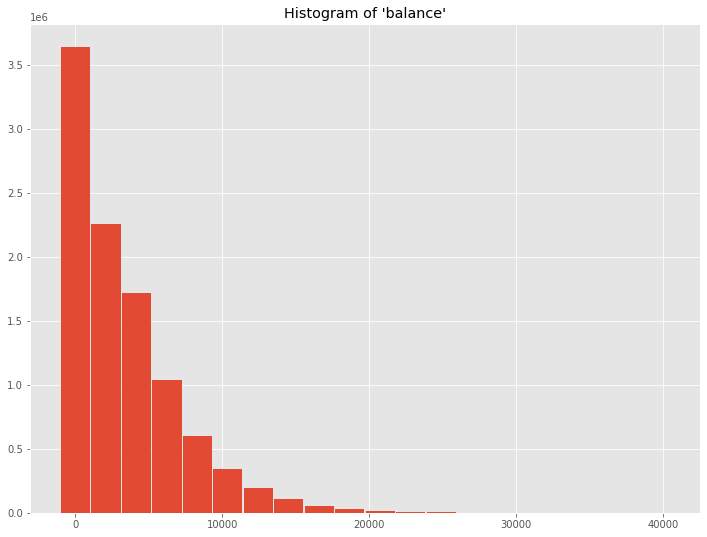

In [36]:
data = {
    'bins': hists[0][:-1],
    'freq': hists[1]
}

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(1, 1, 1)
ax.bar(data['bins'], data['freq'], width=2000)
ax.set_title('Histogram of \'balance\'')

plt.savefig('z_B05793_05_22.png', dpi=300)

In a similar manner, a histogram can be create with Bokeh.

In [37]:
p = bokeh.plotting.figure(
    title="Histogram of 'balance'",
)
p.vbar(x=data["bins"], top=data["freq"], width=1000)
# bokeh.io.output_file("z_vbar.html")
bokeh.io.show(p)

If your data is small enough to fit on the driver (although we would argue it would normally be faster to use the method showed above) you can bring the data and use the `.hist(...)` (from Matplotlib) or `.Histogram(...)` (from Bokeh) methods.

In [38]:
data_driver = {'obs': fraud_df.select('balance').rdd.flatMap(lambda row: row).collect()}

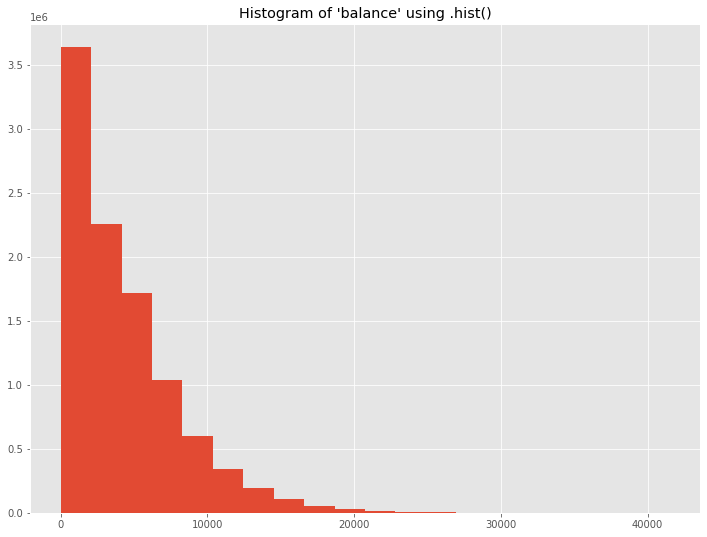

In [39]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(1, 1, 1)

ax.hist(data_driver['obs'], bins=20)
ax.set_title('Histogram of \'balance\' using .hist()')


plt.savefig('B05793_05_24.png', dpi=300)






### Interactions between features

In this example we will sample our fraud dataset at 1% given gender as strata.

In [41]:
data_sample = fraud_df.sampleBy('gender', {1: 0.0002, 2: 0.0002}).select(numerical)

To put multiple 2D charts in one go you can use

In [54]:
data_multi = dict(
    [
        (elem, data_sample.select(elem).rdd.flatMap(lambda row: row).collect()) 
        for elem in numerical
    ]
)

In [64]:
TOOLS = "hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

p = bokeh.plotting.figure(tools=TOOLS)

scaled_balance = [ int(256 * c / max(data_multi['balance']) ) for c in data_multi['balance'] ]

colors = [
    "#%02x%02x%02x" % (c, 256 - c, 15) for c in scaled_balance
]

p.scatter(data_multi['balance'], data_multi['numTrans'], fill_color=colors)

p.xaxis.axis_label = 'balance'
p.yaxis.axis_label = 'numTrans'

# bokeh.io.output_file("z_color_scatter.html", title="color_scatter.py example")

bokeh.io.show(p)  # open a browser


## Chapter's Summary

Exploratory data analysis in pyspark
+ duplicates, missing observations and outliers
   + exact, non-id duplicates, id duplicates
   + count
   + drop duplicates
   + agg
   + functions
   + counts
   + count distinct
   + alias
+ Missin observations
  + where
  + select
  + dropna
  + fillna
+ outliers
  + create bounds and filter outliers
  + approx quartile
  + join
  + select
+ Exploer your data
  + first
  + groupby
  + describe
  + aggregate functions
  + correlations
+ Visualisation
  + histogram
  + interactions between features